# Análise de dados dos servidores do IBAMA

Este notebook faz uma análise dos servidores do IBAMA e processa e agrega o número de servidores por Ano Prodes.

Os dados brutos foram obtidos do [Portal da Transparência](http://www.portaltransparencia.gov.br/download-de-dados/servidores) e do [Painel Estatístico de Pessoal (PEP)](https://www.gov.br/economia/pt-br/acesso-a-informacao/servidores/servidores-publicos/painel-estatistico-de-pessoal).

In [3]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import re

import utils as xu
import xavy.dataframes as xd
import xavy.explore as xe

#### Anotações

**Dúvidas sobre servidores**

* Quais são os servidores que mais fazem falta no combate ao desmatamento? 
    * Fiscais de campo? **R:** Não apenas. A atividade de fiscalização envolve várias etapas (veja abaixo, na conversa com XXXXX).
    * Técnicos que fazem análises prévias? 
    * Temporários contratados pelo PrevFogo?
    * Servidores em unidades avançadas?
* Quais seriam os nomes dos cargos desses servidores? **R:** a partir de 2016, apenas analistas e técnicos ambientais participam da fiscalização. Até 2016, qualquer um, inclusive técnicos e analistas administrativos.
* Em quais unidades eles estão em exercício? **R:** podem estar em unidades centrais relacionadas à fiscalização, ou podem estar nas superintendências (também chamadas SUPES) e nas unidades avançadas.
* Um servidor em exercício em um certo estado costuma atuar fora do estado, ou ele atua majoritariamente nesse estado? **R:** majoritariamente no mesmo estado


**Conversa com XXXXX**

**Diretoria sem relação com a fiscalização e combate ao desmatamento**
* Diretoria de biodiversidade
* Diretoria de qualidade ambiental 

**Outras anotações**

A Diretoria de proteção ambiental (DIPRO) é onde estão os servidores de fiscalização. As superintendências espelham a organização do MMA, com essas diretorias.

RIF Regulamento Interno de Fiscalização, determinou que apenas analistas (e acho que técnicos) ambientais trabalhariam com fiscalização. 
O pessoal do administrativo deixou de fazer isso. Essa modificação aparentemente foi feita em 2016, pois encontramos uma [aprovação do RIF em 2009](https://www.ibama.gov.br/component/legislacao/?view=legislacao&force=1&legislacao=115017) (RIF [aqui](http://www.ibama.gov.br/sophia/cnia/livros/rif.pdf)) sem esse requisito e outra [aprovação em 2016](https://www.in.gov.br/materia/-/asset_publisher/Kujrw0TZC2Mb/content/id/23514630/do1-2016-08-22-portaria-n-24-de-16-de-agosto-de-2016-23514366) com esse requisito. Não foram encontradas outras alterações entre esses dois anos.

Etapas do processo de fiscalização: atuação no campo, análise no escritório de dados/provas, etapa de conciliação, instrução processual e elaboração de relatório  

## Funções

In [7]:
def date_series_to_ano_prodes(series):
    """
    Translate a datetime Series `series`
    into a Prodes year. The Prodes year 
    Y goes from 01/08/Y-1 to 31/07/Y.
    """
    return series.dt.year + (series.dt.month >= 8).astype(int)

In [8]:
def find_uf(string, ufs):
    """
    Given a `string` and a DataFrame of names and 
    acronyms of Brazilian states `ufs` with columns 
    'sigla' and 'nome_upper_s_acento', return the 
    state acronym if its name or acronym is found in 
    `string`. If no state is found, return None.
    """
    
    regexes = r'\b' + ufs['sigla'] + r'\b|\b' + ufs['nome_upper_s_acento'] + r'\b'
    for i in regexes.index:
        regex = regexes[i]
        if bool(re.search(regex, string)) == True:
            return ufs.loc[i, 'sigla']
    
    return None

def find_municipio(string, municipios, return_uf=False):
    """
    Given a `string` and a DataFrame of Brazilian 
    municipalities names and their states acronyms 
    `municipios` with columns 
    'sigla_uf' and 'nome', return the 
    state acronym if the municipality name is found in 
    `string`. If no name is found, return None.
    """
    
    regexes = r'\b' + municipios['nome'] + r'\b'
    for i in regexes.index:
        regex = regexes[i]
        if bool(re.search(regex, string)) == True:
            if return_uf == True:
                return municipios.loc[i, 'sigla_uf']
            else:
                return municipios.loc[i, 'municipio']
    
    return None        

In [9]:
def plot_counts(df, factor=1, color=None, label=None, x_col='data'):
    """
    Create a plot of value counts in Series given by `df[x_col]`. 
    """
    series = df[x_col].value_counts().sort_index()
    series = series * factor
    series.plot(color=color, label=label)

In [10]:
def month_name_to_num(month_name):
    """
    Translate a `month_name` (str) to a number (int) from 
    1 to 12. Works with portuguese and english, and with 
    full name and 3-letter abbreviation.
    """
    
    translate_dict = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 
                      'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12, 
                      'janeiro': 1, 'fevereiro': 2, 'março': 3, 'abril': 4, 'maio': 5, 'junho': 6, 
                      'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12, 
                      'marco': 3, 'feb': 2, 'apr': 4, 'may': 5, 'aug': 8, 'sep': 9, 'oct': 10, 'dec': 12, 
                      'january': 1, 'february': 2, 'march': 3, 'april': 4, 'june': 6, 
                      'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12}
    
    return translate_dict[month_name.lower().strip()]

In [11]:
def agg_servidores_portal(df, bin_name='ano_prodes', valid_bins=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]):
    """
    Compute the number of servidores in a DataFrame `df` 
    with data from Portal da Transparência.
    Bin the counts by `df` column `bin_name` (str)
    and only return counts for bins in `valid_bins` (list).
    """
    n_portal = (df[bin_name].value_counts() / 12).sort_index().loc[valid_bins]
    return n_portal

In [12]:
def agg_servidores_pep(df, bin_name='ano_prodes', min_bin=2011):
    """
    Compute the number of servidores in a DataFrame `df` 
    with data from Painel Estatístico de Pessoal.
    Bin the counts by `df` column `bin_name` (str)
    and only return counts for bins >= `min_bin` (list).
    """
    n_pep = df.loc[(df['Mês'] == 12) & (df[bin_name] >= min_bin)].groupby([bin_name])['Servidores'].sum()
    return n_pep

## Calculando número de servidores por ano prodes 2011-2021

### Carregando os dados

In [96]:
amz_legal = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']

In [97]:
# Carregando os dados do PEP (Painel Estatístico de Pessoal):
pep_ibama = pd.read_excel('../dados/brutos/servidores/n_servidores_ibama_painel_estatistico_pessoal_min_planejamento.xlsx')
# Limpando os dados:
pep_ibama.dropna(subset=['Servidores'], inplace=True)
pep_ibama['Mês'] = pep_ibama['Mês'].apply(month_name_to_num)
pep_ibama['data'] = pep_ibama['Ano'].astype(str) + '-' + pep_ibama['Mês'].astype(str).str.zfill(2) + '-01'
pep_ibama['data'] = pd.to_datetime(pep_ibama['data'])
pep_ibama['ano_prodes'] = date_series_to_ano_prodes(pep_ibama['data'])
# Selecionando dados de servidores ativos:
pep_ibama = pep_ibama.loc[pep_ibama['Grupo Situação do Vínculo'].isin(['Ativo'])]

In [98]:
# Carregando dados do Portal da Transparência:
df = pd.read_csv('../dados/processed/servidores_sem_duplicados_novas_colunas_v01.csv')
df['data'] = pd.to_datetime(df['data'])

### Calculando

In [99]:
n_pep        = agg_servidores_pep(pep_ibama)
n_portal     = agg_servidores_portal(df)
n_servidores = pd.concat([n_pep.loc[:2013], n_portal.loc[2014:]])
n_servidores.name = 'n_servidores_ibama'
n_servidores.index.name = 'ano_prodes'

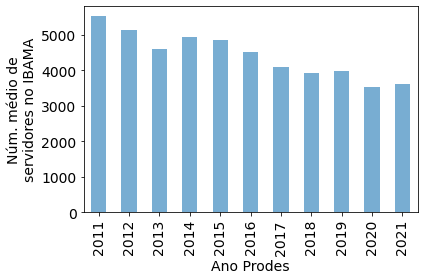

In [109]:
n_servidores.plot(kind='bar', alpha=0.6)
pl.xlabel('Ano Prodes', fontsize=14)
pl.ylabel('Núm. médio de\nservidores no IBAMA', fontsize=14)
pl.tick_params(labelsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/num_servidores_ibama_ano_prodes.png')
pl.show()

In [57]:
# Exporta dados:
#n_servidores.reset_index().to_csv('../dados/processed/numero_servidores_ibama_por_ano_prodes_PortalTransp-PEP.csv', index=False)

### Testes da combinação de dados PEP e Portal da Transparência

Aqui nós verificamos se seria válido combinar os dados sobre número de servidores do Portal da Transparência com o do Painel Estatístico de Pessoal. Na realidade, esse teste foi feito antes do cálculo da seção anterior, mas eu coloquei aqui para organizar melhor o notebook (dado que este é um procedimento auxiliar).

**Conclusões**

* Número de servidores na Amazônia legal é próximo do número de servidores totais do IBAMA.
* Diferença entre número médio de servidores, calculado pelo Portal da Transparência, e número de servidores em dezembro é menor para servidores totais do IBAMA.

**Portanto:** Vamos utilizar como medida de número de servidores o número total de servidores do IBAMA.

In [18]:
# Seleciona dados da amazônia legal:
df_amz  = df.loc[df['uf'].isin(amz_legal)]
pep_amz = pep_ibama.loc[pep_ibama['UF Servidores'].isin(amz_legal)] 

In [19]:
n_pep        = agg_servidores_pep(pep_ibama)
n_portal     = agg_servidores_portal(df)
n_amz_pep    = agg_servidores_pep(pep_amz)
n_amz_portal = agg_servidores_portal(df_amz)

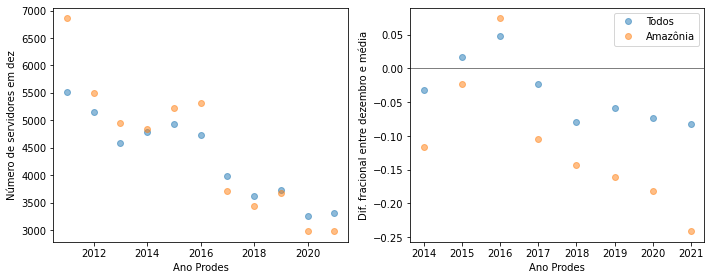

In [39]:
pl.figure(figsize=(10,4))

pl.subplot(1,2,1)
factor = 3.3
n_pep.plot(linewidth=0, marker='o', alpha=0.5, label='Todos')
(factor * n_amz_pep).plot(linewidth=0, marker='o', alpha=0.5, label='Amazônia')
pl.ylabel('Número de servidores em dez')
pl.xlabel('Ano Prodes')

pl.subplot(1,2,2)
((n_pep - n_portal) / n_portal).plot(linewidth=0, marker='o', alpha=0.5, label='Todos')
((n_amz_pep - n_amz_portal) / n_amz_portal).plot(linewidth=0, marker='o', alpha=0.5, label='Amazônia')
pl.axhline(0, color='gray', linewidth=1)
pl.ylabel('Dif. fracional entre dezembro e média')
pl.xlabel('Ano Prodes')
pl.legend()
pl.tight_layout()
pl.show()

## Análise dos dados do Painel Estatístico de Pessoal

Aqui nós verificamos a qualidade dos dados do PEP e o comparamos com os do Portal da Transparência. Em ordem cronológica do projeto, esta parte do notebook foi executada  antes das acima, mas ela foi colocada aqui para melhor organizar o notebook, uma vez que ela é acessória.

### Carregando os dados

In [26]:
# Carregando os dados:
pep_ibama = pd.read_excel('../dados/brutos/servidores/n_servidores_ibama_painel_estatistico_pessoal_min_planejamento.xlsx')
# Limpando os dados:
pep_ibama.dropna(subset=['Servidores'], inplace=True)
pep_ibama['Mês'] = pep_ibama['Mês'].apply(month_name_to_num)
pep_ibama['data'] = pep_ibama['Ano'].astype(str) + '-' + pep_ibama['Mês'].astype(str).str.zfill(2) + '-01'
pep_ibama['data'] = pd.to_datetime(pep_ibama['data'])
pep_ibama['ano_prodes'] = date_series_to_ano_prodes(pep_ibama['data'])

In [27]:
# Selecionando dados de servidores ativos:
#ativos_list = ['Ativo Permanente', 'Contrato Temporario', 'Nomeado Cargo Comis.', 'Req.De Outros Orgaos', 'Ativo Perm L.8878/94']
#ativos_pep_ibama = pep_ibama.loc[pep_ibama['Situação do vínculo'].isin(ativos_list)]
ativos_pep_ibama = pep_ibama.loc[pep_ibama['Grupo Situação do Vínculo'].isin(['Ativo'])]

### Comparação com dados do Portal da Transparência

**Conclusão:** vamos utilizar a medida de número médio de servidores feita a partir dos dados do Portal da Transparência, pois essa é uma medida mais precisa do que pegar os servidores em dezembro, e ela está disponível dos anos-prodes de 2014 a 2021.

Para preencher os dados para os anos prodes 2011 a 2013, vamos utilizar a medida de dezembro do PEP, sem offset. Levando em conta a diferença 
entre essa e a medida do Portal da Transparência para os 2014 a 2017, não vemos uma diferença sistemática e apenas uma dispesão de menos de 5%.

#### Geral (Brasil)

In [28]:
# Carregando dados do Portal da Transparência:
df = pd.read_csv('../dados/processed/servidores_sem_duplicados_novas_colunas_v01.csv')
df['data'] = pd.to_datetime(df['data'])

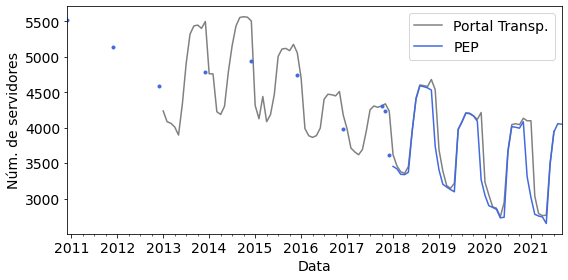

In [60]:
# Comparando os dois dados:
pl.figure(figsize=(8,4))
plot_counts(df, color='gray', label='Portal Transp.')
ativos_pep_ibama.loc[ativos_pep_ibama['Ano'].isin([2018, 2019, 2020, 2021])].groupby(['data'])['Servidores'].sum().plot(color='royalblue', label='PEP')
leg = pl.legend(fontsize=14)
ativos_pep_ibama.loc[ativos_pep_ibama['Ano'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])].groupby(['data'])['Servidores'].sum().plot(color='royalblue', linewidth=0, marker='.')
pl.tick_params(labelsize=14)
pl.rcParams.update({'legend.fontsize': 14})
pl.ylabel('Núm. de servidores', fontsize=14)
pl.xlabel('Data', fontsize=14)
pl.tight_layout()
pl.show()

In [82]:
# Diferença entre número médio de servidores no Ano Prodes calculados pelo Portal da Transparência e PEP:
pep_df = ativos_pep_ibama.loc[ativos_pep_ibama['ano_prodes'].isin([2019,2020,2021])].groupby(['data'])['Servidores'].sum().reset_index()
pep_df['ano_prodes'] = date_series_to_ano_prodes(pep_df['data'])
transp_counts = (df['ano_prodes'].value_counts() / 12).sort_index().loc[2019:]
pep_counts = pep_df.groupby('ano_prodes')['Servidores'].mean()
(transp_counts - pep_counts) / pep_counts

2019    0.035512
2020    0.039051
2021    0.061249
dtype: float64

In [62]:
# Diferença entre dado de dezembro do PEP e média do PEP no Ano Prodes:
dec_counts = ativos_pep_ibama.loc[ativos_pep_ibama['Mês'] == 12].groupby('ano_prodes')['Servidores'].sum().loc[2019:]
(dec_counts - pep_counts) / pep_counts

ano_prodes
2019   -0.025999
2020   -0.037725
2021   -0.025706
Name: Servidores, dtype: float64

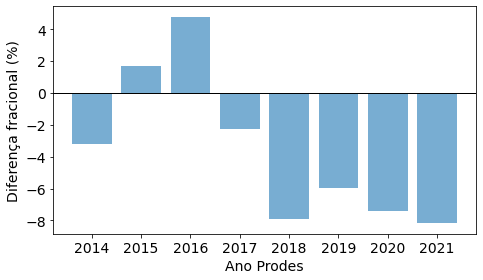

In [83]:
# Diferença entre dados de dezembro do PEP e média do Portal da Transparência
dec_counts = ativos_pep_ibama.loc[ativos_pep_ibama['Mês'] == 12].groupby('ano_prodes')['Servidores'].sum().loc[2014:]
transp_counts = (df['ano_prodes'].value_counts() / 12).sort_index().loc[2014:]

pl.figure(figsize=(7,4))
frac_diff = (dec_counts - transp_counts) / transp_counts
pl.bar(frac_diff.index, frac_diff * 100, alpha=0.6)
pl.axhline(0, linewidth=1, color='k')
pl.tick_params(labelsize=14)
pl.xlabel('Ano Prodes', fontsize=14)
pl.ylabel('Diferença fracional (%)', fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/dif_fracional_num_servidores_ibama_PEP_Portal.png')
pl.show()

In [92]:
print('Desvio até 2017:', frac_diff.loc[:2017].std())
print('Média a partir de 2018:', frac_diff.loc[2018:].mean())
print('Desvio a partir de 2018:', frac_diff.loc[2018:].std())

Desvio até 2017: 0.036850196281140675
Média a partir de 2018: -0.07353743949259542
Desvio a partir de 2018: 0.009991755347955477


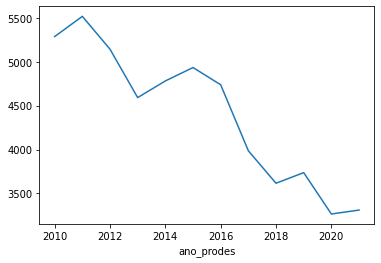

In [13]:
# Dados de dezembro do PEP para o período 2010-2021
dec_counts = ativos_pep_ibama.loc[ativos_pep_ibama['Mês'] == 12].groupby('ano_prodes')['Servidores'].sum().loc[2010:]
dec_counts.plot()
pl.show()

#### Comparação entre dados dos estados

A proposta era fazer um mapeamento do número de servidores do IBAMA em cada estado, mas os dados estaduais ficam muito ruidosos. Então essa proposta foi abandonada.

In [14]:
amz_legal = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']
all_ufs   = df['uf'].unique()

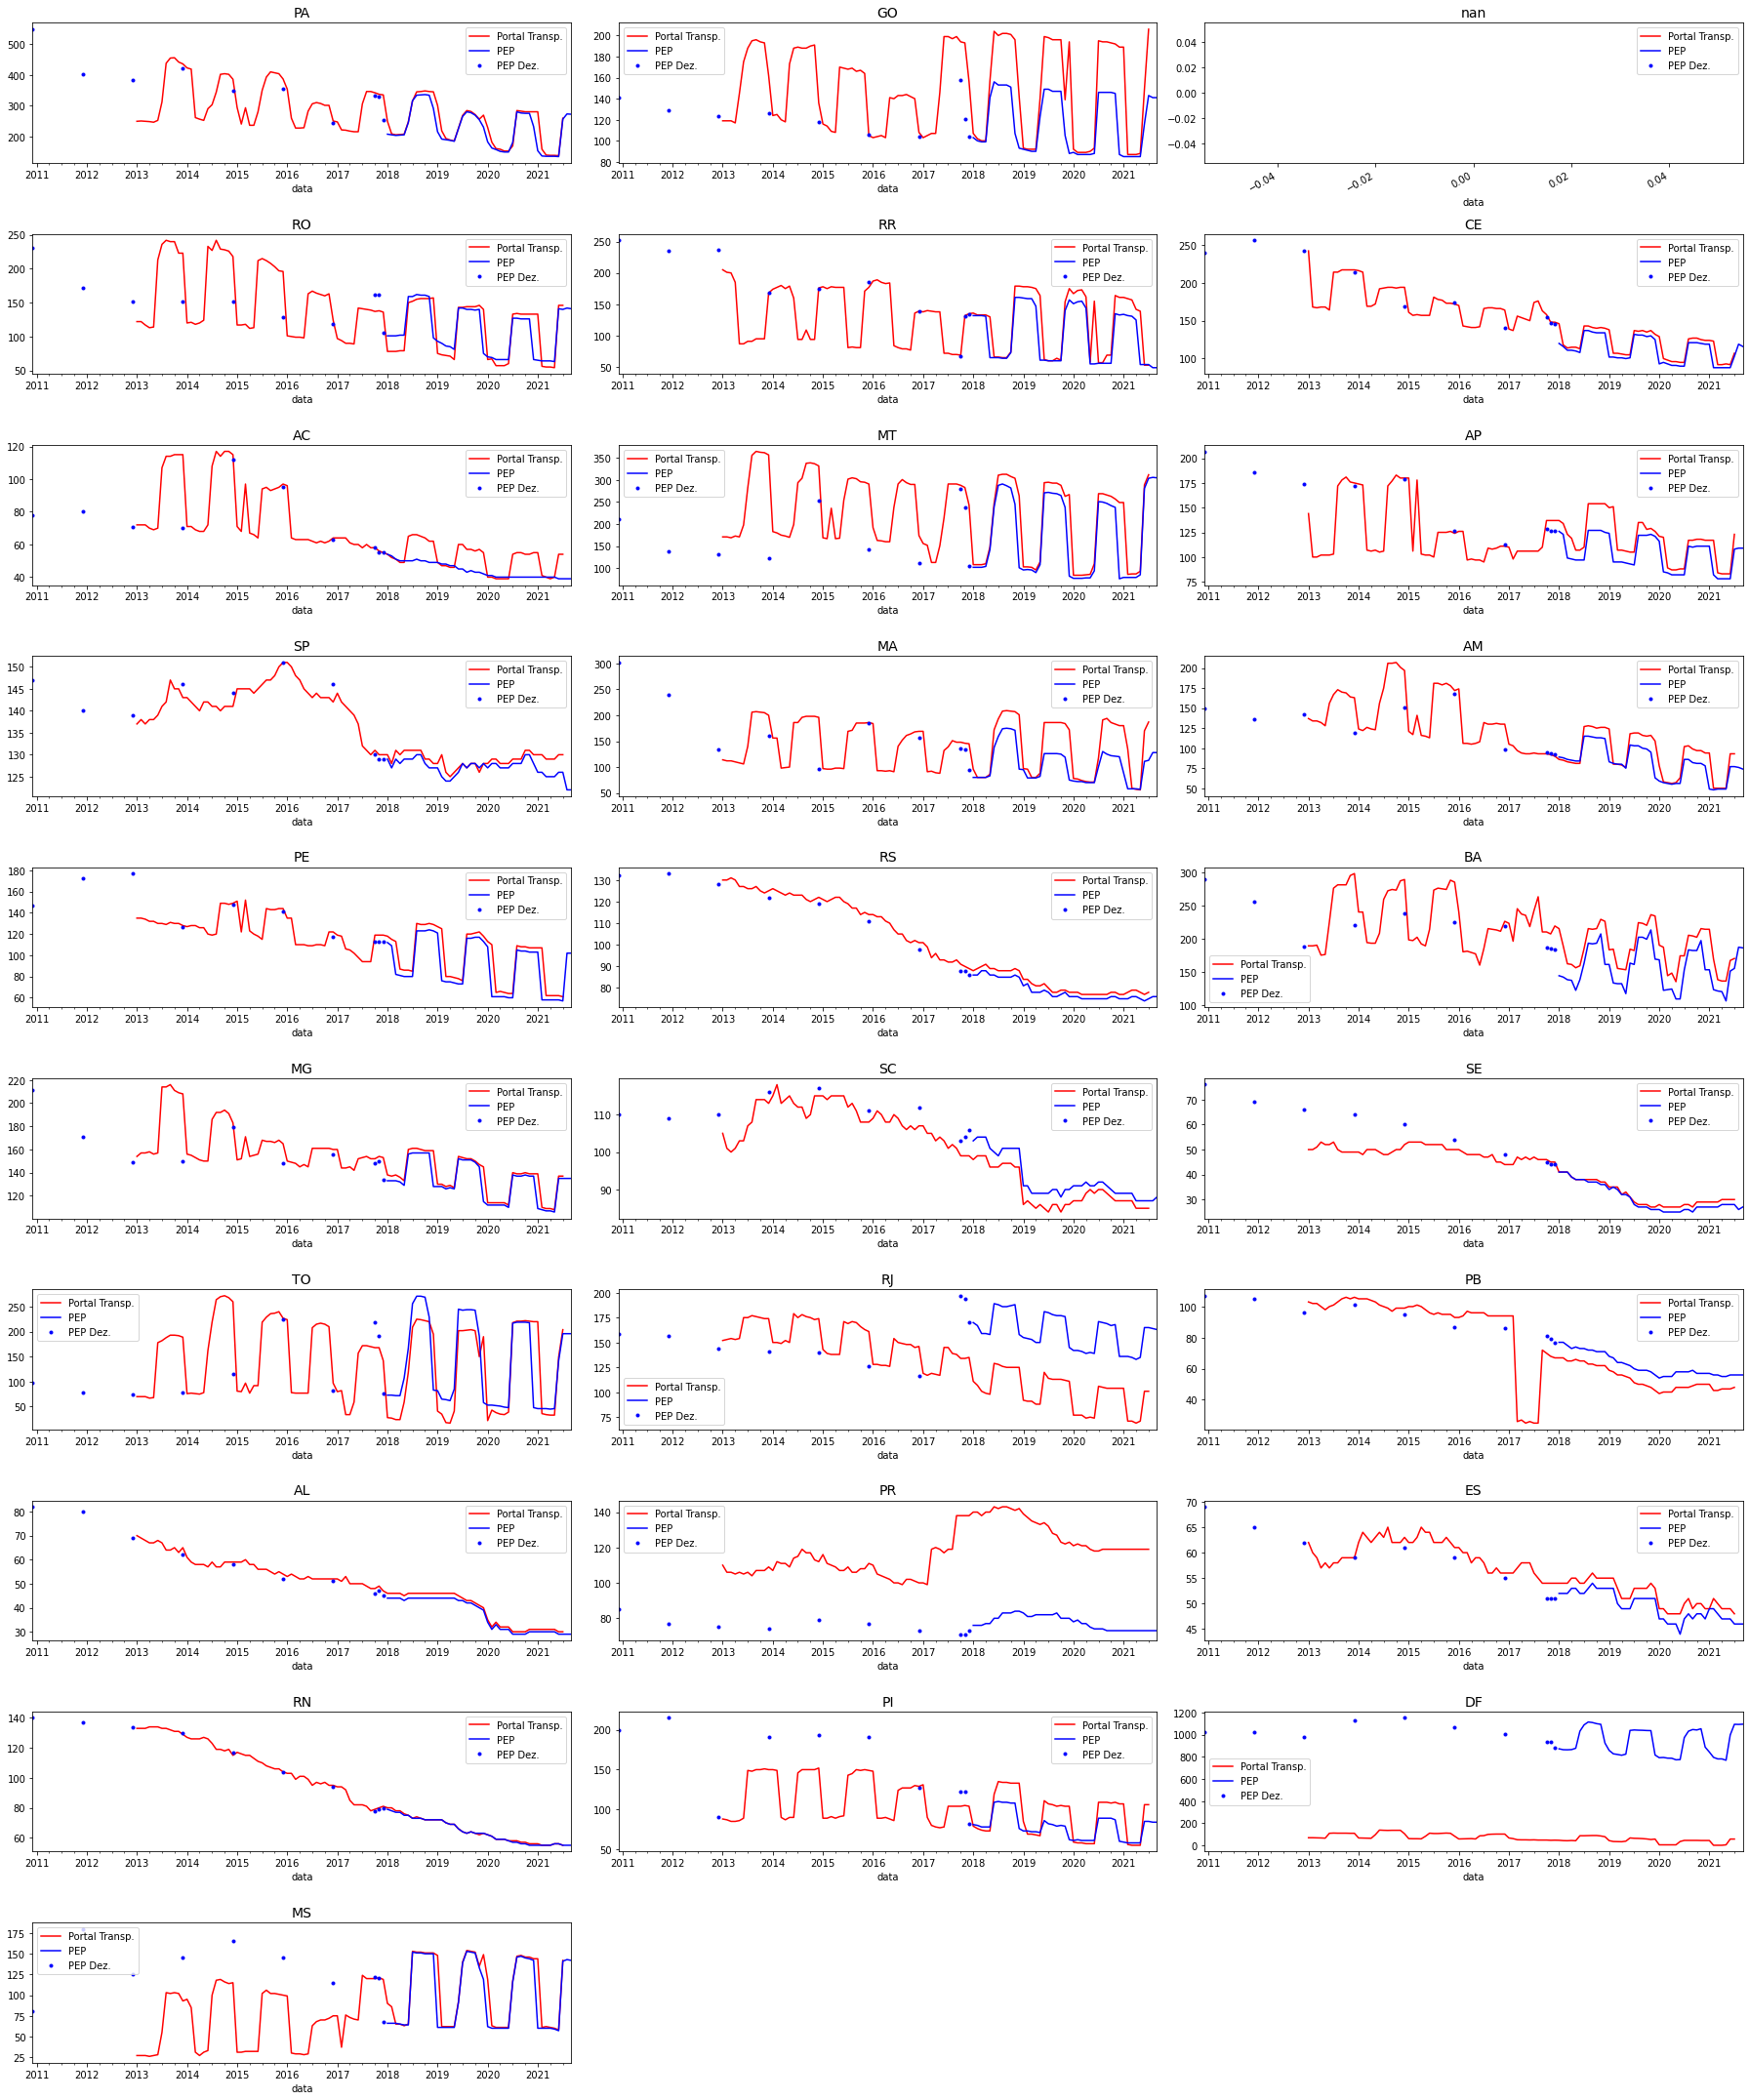

In [15]:
# Comparando os dois dados:
pl.figure(figsize=(25,30))
for i, uf in enumerate(all_ufs):
    pl.subplot(10, 3, i+1)
    plot_counts(df.loc[df['uf'] == uf], color='red', label='Portal Transp.')
    uf_pep_ibama = ativos_pep_ibama.loc[ativos_pep_ibama['UF Servidores'] == uf]
    uf_pep_ibama.loc[uf_pep_ibama['Ano'].isin([2018, 2019, 2020, 2021])].groupby(['data'])['Servidores'].sum().plot(color='b', label='PEP')
    uf_pep_ibama.loc[uf_pep_ibama['Ano'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])].groupby(['data'])['Servidores'].sum().plot(color='b', linewidth=0, marker='.', label='PEP Dez.')
    pl.legend()
    pl.title(uf, fontsize=14)
pl.tight_layout()
pl.show()

**PS:** Existe um bug no plot abaixo que faz com que, quando temos apenas dados de dezembro de cada ano, os dados aparecem no plot na posição de janeiro do ano em questão (i.e. quase um ano antes da sua posição real).

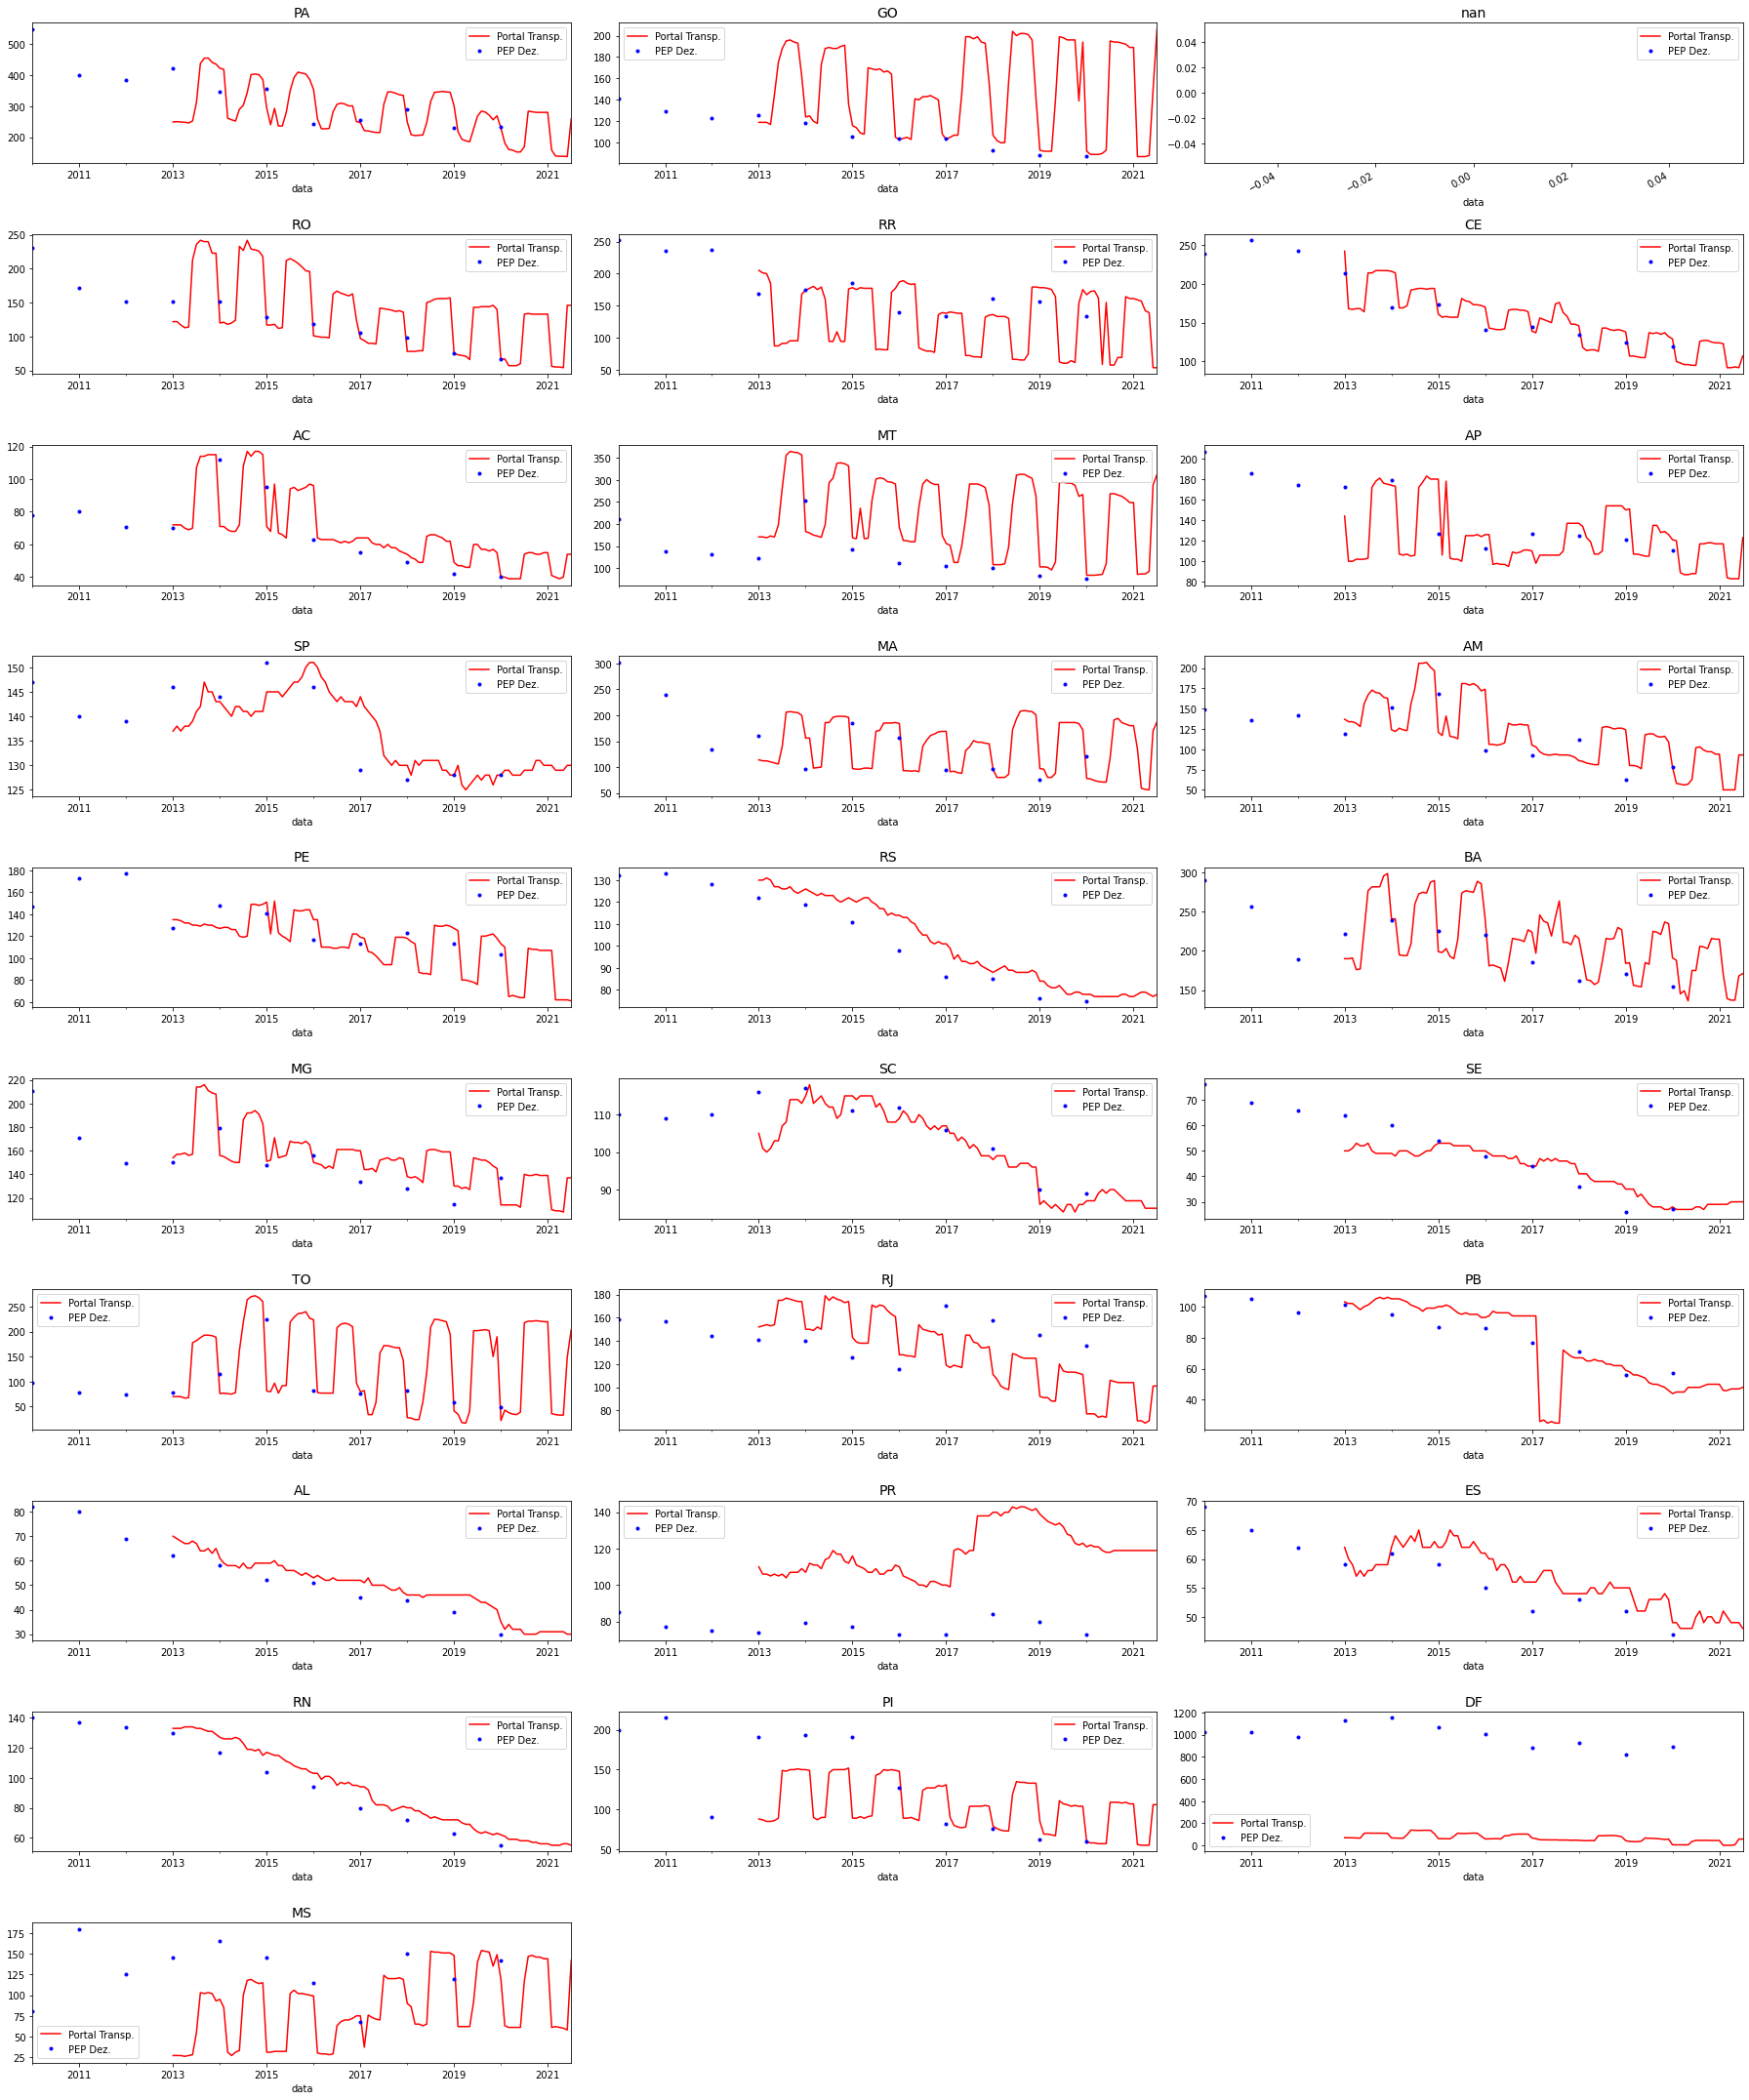

In [16]:
# Comparando os dois dados:
pl.figure(figsize=(25,30))
for i, uf in enumerate(all_ufs):
    pl.subplot(10, 3, i+1)
    plot_counts(df.loc[df['uf'] == uf], color='red', label='Portal Transp.')
    uf_pep_ibama = ativos_pep_ibama.loc[ativos_pep_ibama['UF Servidores'] == uf]
    uf_pep_ibama.loc[(uf_pep_ibama['Mês'] == 12) & (uf_pep_ibama['Ano'] >= 2010)].groupby(['data'])['Servidores'].sum().plot(color='b', linewidth=0, marker='.', label='PEP Dez.')
    pl.legend()
    pl.title(uf, fontsize=14)
pl.tight_layout()
pl.show()

### Modelo de imputação de dados

A ideia dessa seção era preencher os dados faltantes utilizando um modelo de Redes Neurais Recorrentes, mas essa proposta foi abandonada.

#### Organizando os dados

In [17]:
# Cria alvo: número médio de servidores:
y_series = (df.groupby('uf')['ano_prodes'].value_counts() / 12).sort_index(ascending=False)
y_series.name = 'n_medio_target'

# Cria feature: # de servidores em dezembro do ano prodes em questão:
pep_dez = ativos_pep_ibama.loc[(ativos_pep_ibama['Mês'] == 12) & (ativos_pep_ibama['ano_prodes'] > 2012)].groupby(['UF Servidores', 'ano_prodes'])['Servidores'].sum().sort_index(ascending=False)
pep_dez.name = 'n_dez'

# Cria feature: # de servidores em dezembro do ano prodes anterior:
pep_dez_anterior = pep_dez.shift()
pep_dez_anterior.name = 'n_dez_anterior'
pep_dez_anterior = pep_dez_anterior.reset_index()
pep_dez_anterior.loc[~xu.same_as_previous_entry(pep_dez_anterior[['UF Servidores']]), 'n_dez_anterior'] = np.NaN

# Cria feature: # médio de servidores no ano prodes seguinte (anterior se voltando no tempo):
x_series = y_series.shift()
x_series.name = 'n_medio_anterior'
x_series = x_series.reset_index()
x_series.loc[~xu.same_as_previous_entry(x_series[['uf']]), 'n_medio_anterior'] = np.NaN

In [18]:
# Junta os dados acima:
Xy_df = x_series.join(pep_dez, how='inner', on=['uf', 'ano_prodes']).join(pep_dez_anterior.set_index(['UF Servidores', 'ano_prodes']), how='inner', on=['uf', 'ano_prodes']).join(y_series, how='inner', on=['uf', 'ano_prodes'])
# Elimina dados ruins:
Xy_df = Xy_df.dropna()
Xy_df = Xy_df.loc[~Xy_df['uf'].isin(['DF', 'PR', 'RJ', 'PB'])]

#### Train-test split

In [19]:
frac_test  = 0.2
seed       = 90989

sample_ufs = Xy_df['uf'].unique()
n_samples  = len(sample_ufs)
n_test     = int(np.round(frac_test * n_samples))
sample_idx = np.arange(n_samples)
np.random.seed(seed)
np.random.shuffle(sample_idx)
build_idx  = sample_idx[:n_samples - n_test]
test_idx   = sample_idx[n_samples - n_test:]
test_ufs   = sample_ufs[test_idx]
build_ufs  = sample_ufs[build_idx]

build_Xy_df = Xy_df.loc[Xy_df['uf'].isin(build_ufs)]
test_Xy_df  = Xy_df.loc[Xy_df['uf'].isin(test_ufs)]

#### Modelos baseline

In [20]:
print('Prevendo valor do ano anterior: {:.2f}'.format(np.std(build_Xy_df['n_medio_anterior'] - build_Xy_df['n_medio_target'])))

uf_factor = (build_Xy_df['n_medio_anterior'] / build_Xy_df['n_dez_anterior']).groupby(build_Xy_df['uf']).mean()
uf_factor.name = 'factor'
temp_df = build_Xy_df.join(uf_factor, on='uf')
print('Prevendo valor de dezembro multiplicado pela média da razão entre # médio e dezembro: {:.2f}'.format(np.std(temp_df['n_dez'] * temp_df['factor'] - build_Xy_df['n_medio_target'])))

print('Prevendo valor de dezembro multiplicado pela razão entre # médio e dezembro anteriores: {:.2f}'.format(np.std(build_Xy_df['n_medio_anterior'] / build_Xy_df['n_dez_anterior'] * build_Xy_df['n_dez'] - build_Xy_df['n_medio_target'])))

Prevendo valor do ano anterior: 34.99
Prevendo valor de dezembro multiplicado pela média da razão entre # médio e dezembro: 43.05
Prevendo valor de dezembro multiplicado pela razão entre # médio e dezembro anteriores: 41.72


#### Modelo Linear

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import mltools as ml

In [31]:
linear_model = LinearRegression(normalize=False)

In [34]:
param_grid = {'fit_intercept': [True, False]}
grid = GridSearchCV(linear_model, param_grid, scoring='neg_root_mean_squared_error', return_train_score=True)

In [36]:
dump = grid.fit(build_Xy_df[['n_medio_anterior', 'n_dez', 'n_dez_anterior']], build_Xy_df['n_medio_target'])

In [40]:
ml.searchCV_table(grid)

,mean_fit_time,std_fit_time,param_fit_intercept,mean_test_score,std_test_score,mean_train_score,std_train_score
0,0.002276,0.000178,True,-30.756716,11.937326,-31.085325,3.408139
1,0.002314,0.000365,False,-30.846907,11.997631,-31.349000,3.461680


#### Modelo RandomForest

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import mltools as ml

In [78]:
random_forest = RandomForestRegressor()

In [82]:
param_grid = {'max_depth': [2, 6, 10], 
              'min_samples_split': [2, 4, 8]}
grid = GridSearchCV(random_forest, param_grid, scoring='neg_root_mean_squared_error', return_train_score=True)

In [83]:
dump = grid.fit(build_Xy_df[['n_medio_anterior', 'n_dez', 'n_dez_anterior']], build_Xy_df['n_medio_target'])

/home/skems/prog/my-python/mltools.py:1651: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


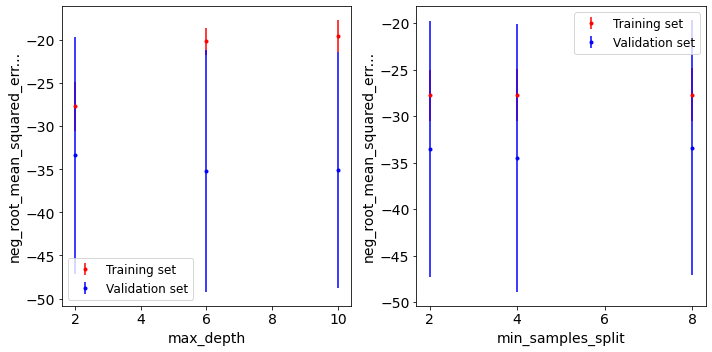

In [84]:
ml.plot_pars_scores(grid)

#### Modelo RNN

In [41]:
import tensorflow as tf

In [42]:
def df_to_seq2seq(df, seq_id, features, target):
    """
    Format the data in `df` (DataFrame) into a batch of sequences 
    of features and a batch of target sequences.
    
    Parameters
    ----------
    df : DataFrame
        A DataFrame containing the features and the target, along
        with a column that identifies the sequence (all sequences
        are stored in the same DataFrame).
    seq_id : str
        Column of the sequence identifier (ID) in `df`.
    features : str of list of str
        Columns containing the instances' features.
    target : str or list of str
        Columns containing the instances' target values y.
    
    Returns
    -------
    
    X : array
        An array of shape (n_sequences, n_steps, n_features) containing
        a batch of sequences of features. It assumes all sequences have 
        the same length.
    y : array
        An array of shape (n_sequences, n_steps, n_targets) containing 
        a batch of sequences of targets (usually there is only one 
        target). It assumes all sequences have 
        the same length.
    """
    
    # Standardize input: 
    if type(target) == str:
        target = [target]
    # Standardize input: 
    if type(features) == str:
        features = [features]

    # Select sequence labels:
    seq_ids = df[seq_id].unique()

    # Build batch of sequences:
    X = np.array([df.loc[df[seq_id] == seq][features].values for seq in seq_ids])
    y = np.array([df.loc[df[seq_id] == seq][target].values for seq in seq_ids])
    
    return X, y

In [43]:
# Build model:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(8,2)))
model.add(tf.keras.layers.LSTM(10, return_sequences=True))
model.add(tf.keras.layers.LSTM(10, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error')
#model.save_weights('../dados/aux/lstm_servidores_imputer_random_weights.h5')

In [46]:
n_splits = 5
seed     = 653929

seq_ufs  = build_Xy_df['uf'].unique()
n_seqs   = len(seq_ufs)
n_val    = int(np.round(n_seqs / n_splits))
np.random.seed(seed)
seq_idx = np.arange(n_seqs)
np.random.shuffle(seq_idx)
seq_ufs  = seq_ufs[seq_idx]

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True)

train_loss = []
val_loss   = []
histories  = []
for i in range(n_splits):
    print('Split {}/{}:'.format(i + 1, n_splits), end=' ')
    
    # Split validation and test sets:
    val_ufs  = seq_ufs[i * n_val: (i + 1) * n_val]
    train_df = build_Xy_df.loc[~build_Xy_df['uf'].isin(val_ufs)].copy()
    val_df   = build_Xy_df.loc[build_Xy_df['uf'].isin(val_ufs)].copy()
    
    # Standardizing data:
    X_mean = train_df[['n_medio_anterior', 'n_dez']].mean()
    X_dev  = train_df[['n_medio_anterior', 'n_dez']].std()
    train_df.loc[:, ['n_medio_anterior', 'n_dez']] = (train_df.loc[:, ['n_medio_anterior', 'n_dez']] - X_mean) / X_dev
    val_df.loc[:, ['n_medio_anterior', 'n_dez']]   = (val_df.loc[:, ['n_medio_anterior', 'n_dez']] - X_mean) / X_dev
    
    # Reshaping into batches of sequences:
    X_train, y_train = df_to_seq2seq(train_df, 'uf', ['n_medio_anterior', 'n_dez'], 'n_medio_target')
    X_val,   y_val   = df_to_seq2seq(val_df, 'uf', ['n_medio_anterior', 'n_dez'], 'n_medio_target')
    
    # Reset weights and fit model:
    model.load_weights('../dados/aux/lstm_servidores_imputer_random_weights.h5')
    history = model.fit(X_train, y_train, batch_size=X_train.shape[0], epochs=30000, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stop])
    
    # Get statistics:
    min_idx = np.argmin(history.history['val_loss'])
    n_epochs    = len(history.history['loss'])
    train_score = np.sqrt(history.history['loss'][min_idx])
    val_score   = np.sqrt(history.history['val_loss'][min_idx])
    
    # Save statistics:
    train_loss.append(train_score)
    val_loss.append(val_loss)
    histories.append(history.history)
    
    print(' # epochs: {}  -  Train RMSE: {:.2f}  -  Val RMSE: {:.2f}'.format(n_epochs, train_score, val_score))

In [ ]:
np.mean(val_loss)

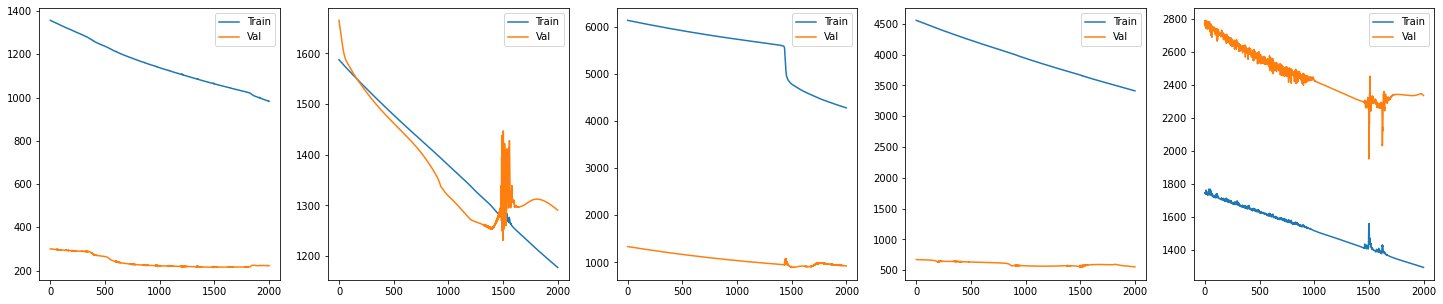

In [100]:
pl.figure(figsize=(25,5))
for i, h in enumerate(histories):
    pl.subplot(1, 5, i + 1)
    pl.plot(h['loss'][-2000:], label='Train')
    pl.plot(h['val_loss'][-2000:], label='Val')
    pl.legend()
pl.show()

# Processamento de dados do Portal da Transparência

Esta seção pega os dados brutos de servidores, obtidas do Portal da Transparência, e os analisa para criarmos uma pipeline que os limpe e possa transformá-los em uma contagem por Ano Prodes.

Em ordem cronológica do projeto, esta parte do notebook foi executada  antes das acima, mas ela foi colocada aqui para melhor organizar o notebook, uma vez que ela é acessória.

## Carrregando os dados

In [13]:
ufs        = pd.read_csv('../dados/aux/sigla_uf_nomes.csv')
municipios = pd.read_csv('../dados/aux/cod_municipios_ibge_tse.csv')
municipios['nome'] = municipios['municipio'].str.upper().apply(xu.remove_accents)
municipios['tamanho_nome'] = municipios['nome'].str.len()

In [14]:
# Carregando os dados:
df = pd.read_csv('../dados/limpos/servidores_ibama/servidores_ibama_2013-01_2021_07.csv', low_memory=False)
# Preparo básico:
df['data'] = pd.to_datetime(df['data'])
df['ano_prodes'] = date_series_to_ano_prodes(df['data'])
df['mes'] = df['data'].dt.month

# Eliminando duplicados:
df = df.sort_values(['data', 'id_servidor', 'sigla_funcao', 'situacao_vinculo'], ascending=[True, True, False, False]).drop_duplicates(subset=['data', 'id_servidor'], keep='first')

# Padronizando nomes de unidades:
df['uorg_exercicio'] = df['uorg_exercicio'].str.upper().apply(xu.remove_accents)

### Identificação do estado

In [15]:
amz_legal = ['AC', 'AM', 'AP', 'MA', 'MT', 'PA', 'RO', 'RR', 'TO']

# Seleciona municípios com nomes únicos no Brasil:
municipios_unicos = municipios.drop_duplicates(subset='nome', keep=False)
municipios_unicos = municipios_unicos.sort_values('tamanho_nome', ascending=False)

# Retira os com nomes ambíguos:
nomes_ambiguos = ['UNIAO', 'FLORESTAL', 'VITORIA', 'SAUDE', 'CRUZEIRO', 'ESTACAO', 'PONTAL', 'RESERVA']
municipios_unicos = municipios_unicos.loc[~municipios_unicos['nome'].isin(nomes_ambiguos)]

In [16]:
# Junta diferentes nomes de unidades com o mesmo código:
nome_unidades_por_cod = df.groupby('cod_uorg_exercicio')['uorg_exercicio'].unique().str.join(' / ')

# Cria DataFrame:
unidades_df = pd.DataFrame()
unidades_df['uorg_exercicio_geral'] = nome_unidades_por_cod

# Identifica UFs:
unidades_df['uf'] = unidades_df['uorg_exercicio_geral'].apply(lambda s: find_uf(s, ufs))

# Identifica UFs via municípios:
unidades_df.loc[unidades_df['uf'].isnull(), 'municipio'] = unidades_df.loc[unidades_df['uf'].isnull(), 'uorg_exercicio_geral'].apply(lambda s: find_municipio(s, municipios_unicos))
unidades_df.loc[unidades_df['uf'].isnull(), 'uf']        = unidades_df.loc[unidades_df['uf'].isnull(), 'uorg_exercicio_geral'].apply(lambda s: find_municipio(s, municipios_unicos, return_uf=True))

# Junta os nomes das unidades:
len_df = len(df)
df = df.join(unidades_df, how='left', on='cod_uorg_exercicio')
assert len_df == len(df)

In [17]:
#df.to_csv('../dados/processed/servidores_sem_duplicados_novas_colunas_v01.csv', index=False)

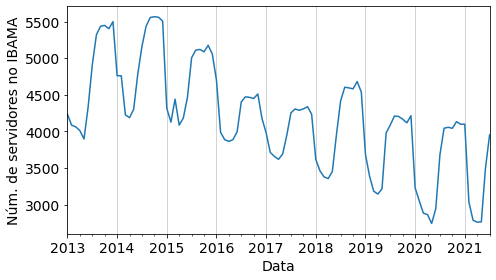

In [25]:
pl.figure(figsize=(7,4))
plot_counts(df)
pl.tick_params(labelsize=14)
pl.ylabel('Núm. de servidores no IBAMA', fontsize=14)
pl.xlabel('Data', fontsize=14)
pl.tight_layout()
pl.grid(axis='x', color='lightgray', linewidth=1)
#pl.savefig('../resultados/plots/num_servidores_ibama_mensal.png')

#### Comparação de servidores federais e localizados nos estados

In [10]:
federal  = df.loc[df['uf'].isnull()]
estadual = df.loc[~df['uf'].isnull()]

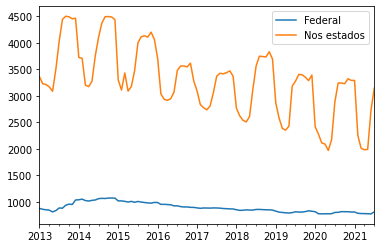

In [11]:
plot_counts(federal, label='Federal')
plot_counts(estadual, label='Nos estados')
pl.legend()
pl.show()

### Classificação das unidades de exercício

In [45]:
# Salvando lista de unidades para classificar:
#df['uorg_exercicio_geral'].drop_duplicates().sort_values().reset_index()[['uorg_exercicio_geral']].to_csv('../dados/processed/unidades_exercicio_classificadas_manualmente_vazia.csv', index=False)

In [48]:
uclass = pd.read_csv('../dados/processed/unidades_exercicio_classificadas_manualmente.csv').set_index('uorg_exercicio_geral')

In [51]:
len_df = len(df)
df = df.join(uclass, on='uorg_exercicio_geral', how='left')
assert len_df == len(df)

In [104]:
gen   = df.loc[df['classe'].isin(['genérica'])]
other = df.loc[df['classe'].isin(['não relacionada'])]
sel   = df.loc[df['classe'].isin(['formação', 'conservação', 'florestal'])]

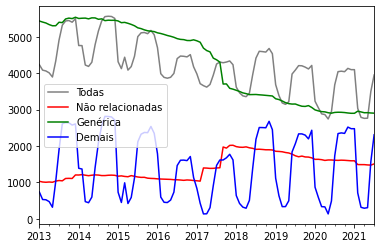

In [107]:
plot_counts(df, color='gray', label='Todas')
plot_counts(other, color='r', factor=1.7, label='Não relacionadas')
plot_counts(gen, color='g', factor=1.7, label='Genérica')
plot_counts(sel, color='b', factor=1.7, label='Demais')
pl.legend()
pl.show()

Vemos acima que houve uma migração brusca entre classes de unidades, um sinal de mudança de nomenclatura. Nossa classificação está sujeita a esse tipo de coisa. Por isso, não vamos utilizá-la.

## EDA (Exploratory Data Analysis)

### Clustering

In [10]:
import xavy.clustering as xc
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder

In [11]:
# Preprocess categorical variables:
enc = OneHotEncoder()
sample_df = df[['desc_cargo', 'sigla_funcao', 'nivel_funcao', 'atividade', 'org_lotacao', 'situacao_vinculo', 'regime_juridico']].sample(10000)
categories = enc.fit_transform(sample_df)
cat_arr = categories.toarray()

In [ ]:
# Plot dendrogram:
pl.figure(figsize=(25,10))
xc.plot_dendrogram(cat_arr, verbose=True, method='ward', metric='euclidean', p=6)

In [13]:
# Cluster data and add cluster label to it:
hierarchy = AgglomerativeClustering(n_clusters=5)
y_clusters =  hierarchy.fit_predict(cat_arr)
sample_df['cluster'] = pd.Series(y_clusters, index=sample_df.index)

sample_df['cluster'].value_counts(normalize=True)

3    0.3384
4    0.2812
1    0.1741
0    0.1353
2    0.0710
Name: cluster, dtype: float64

In [14]:
# Inspect clusters:
i = 2
display(sample_df.loc[sample_df['cluster'] == i].mode())
xu.mapUnique(sample_df.loc[sample_df['cluster'] == i])

,desc_cargo,sigla_funcao,nivel_funcao,atividade,org_lotacao,situacao_vinculo,regime_juridico,cluster
0,Sem informação,DAS,1012,CHEFE DE DIVISAO,Instituto Brasileiro do Meio Ambiente e Recur,ATIVO PERMANENTE,REGIME JURIDICO UNICO,2



desc_cargo: 1 unique values.
Sem informação

sigla_funcao: 2 unique values.
DAS,  FPE

nivel_funcao: 7 unique values.
1011,  1012,  1013,  1014,  1015,  1016,  1023

atividade: 24 unique values.
(sample) ASSESSOR,  ASSESSOR CHEFE,  ASSESSOR TECNICO,  AUDITOR CHEFE,  CHEFE,  CHEFE DE ASSESSORIA,  CHEFE DE CENTRO,  CHEFE DE DIVISAO,  CHEFE DE ESCRITORIO REGIONAL,  CHEFE DE GABINETE,  CHEFE DE SERVICO,  CHEFE DE SERVIfO,  CHEFE DE UNIDADE II,  COORDENADOR,  COORDENADOR GERAL,  CORREGEDOR,  DIRETOR,  GERENTE EXECUTIVO,  PROCURADOR CHEFE,  SUPERINTENDENTE

org_lotacao: 13 unique values.
Advocacia-Geral da União,  Agência Nacional de Águas,  Controladoria-Geral da União,  Câmara dos Deputados,  Empresa Brasileira de Pesquisa Agropecuária,  Fundo Nacional de Desenvolvimento da Educação,  Governo do Estado do Rio de Janeiro,  Instituto Brasileiro do Meio Ambiente e Recur,  Instituto Chico Mendes de Conservação da Biod,  Ministério da Economia,  Ministério da Educação,  Ministério do Meio Ambi

**Conclusões**
* O grupo mais numeroso (33%) de servidores é o de ANALISTA AMBIENTAL sem Função Comissionada, que são servidores efetivos do IBAMA mesmo.
* Em seguida (28%) temos os TÉCNICOS ADMINISTRATIVOS sem Função Comissionada, também servidores efetivos do IBAMA mesmo.
* Em seguida (18%) temos os de CONTRATO TEMPORÁRIO com cargo Inválido.
* Depois, temos servidores variados sem Função comissionada (14%).
* Por último, os servidores variados com Função comissionada (6%).

### Investigação dos com contrato temporário

In [6]:
temporarios = df.loc[df['situacao_vinculo'] == 'CONTRATO TEMPORARIO']
temporarios['desc_cargo'].value_counts(normalize=True)

Inválido    1.0
Name: desc_cargo, dtype: float64

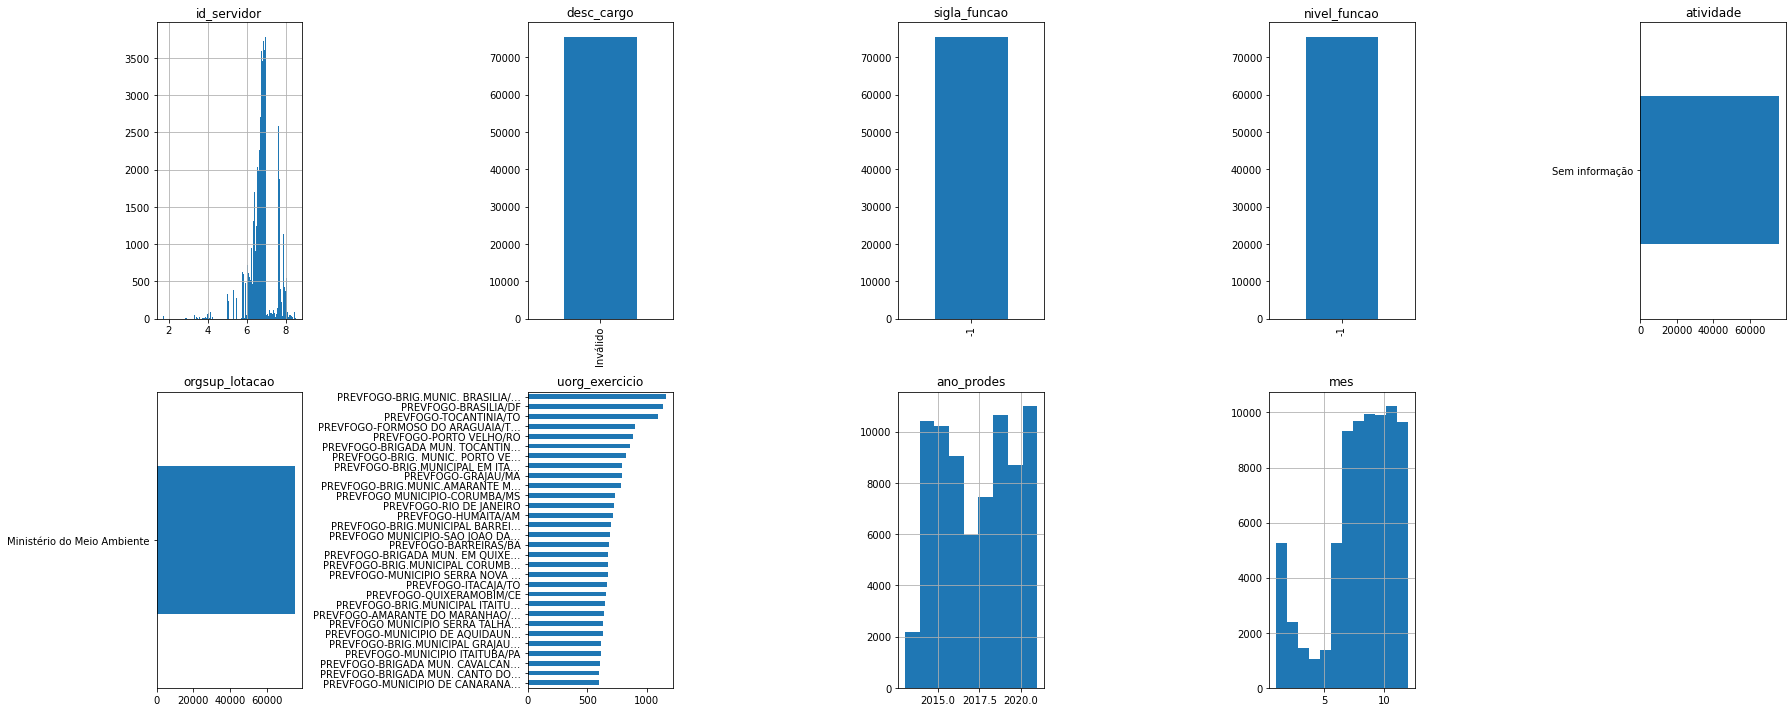

In [9]:
dtypes = [None, 'log', 'cat', 'cat', 'cat', 'cat', None, None, None, None, None, 'cat', None, 'cat', None, None, None, None, None, None, 'num', 'num']
xe.multiple_dist_plots(temporarios, dtypes)

In [35]:
prevfogo_regex = r'PRE[FV]E?[VF]{1,2}OGO?|PREFO\-BRIG'
prevfogo = temporarios.loc[temporarios['uorg_exercicio'].str.contains(prevfogo_regex)]
print('PREVFOGO corresponde a {:.1f}% dos TEMPORARIOS'.format(len(prevfogo) / len(temporarios) * 100))

PREVFOGO corresponde a 98.9% dos TEMPORARIOS


In [38]:
df.loc[df['uorg_exercicio'].str.contains(prevfogo_regex), 'situacao_vinculo'].value_counts(normalize=True)

CONTRATO TEMPORARIO    0.996082
ATIVO PERMANENTE       0.003918
Name: situacao_vinculo, dtype: float64

### Evolução temporal dos diferentes cargos

In [20]:
def servidor_counts_by_date(df, col, keys, negate=False, time_col='data'):
    
    # Standardizing input:
    if type(keys) == str:
        keys = [keys]
        
    # Select cargos:
    if negate:
        sel = df.loc[~df[col].isin(keys)]
    else:
        sel = df.loc[df[col].isin(keys)]
    
    return sel[time_col].value_counts().sort_index()

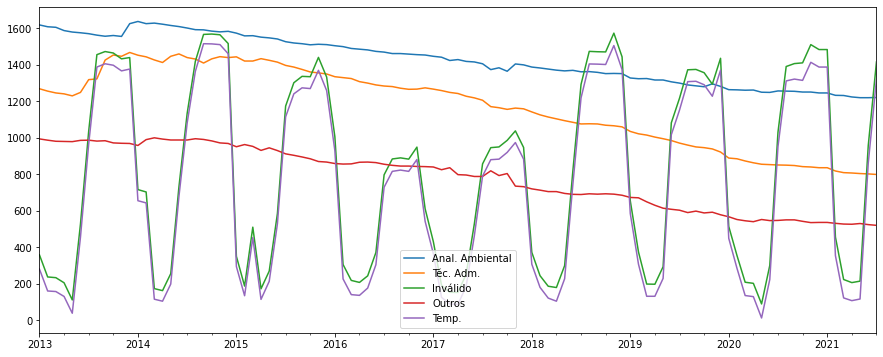

In [21]:
pl.figure(figsize=(15,6))
servidor_counts_by_date(df, 'desc_cargo', 'ANALISTA AMBIENTAL').plot(label='Anal. Ambiental')
servidor_counts_by_date(df, 'desc_cargo', 'TECNICO ADMINISTRATIVO').plot(label='Téc. Adm.')
servidor_counts_by_date(df, 'desc_cargo', 'Inválido').plot(label='Inválido')
servidor_counts_by_date(df, 'desc_cargo', ['ANALISTA AMBIENTAL', 'Inválido','TECNICO ADMINISTRATIVO'], negate=True).plot(label='Outros')
servidor_counts_by_date(df, 'situacao_vinculo', 'CONTRATO TEMPORARIO').plot(label='Temp.')

pl.legend()
pl.show()

In [32]:
servidor_counts_df = pd.DataFrame()
servidor_counts_df['analista'] = servidor_counts_by_date(df, 'desc_cargo', 'ANALISTA AMBIENTAL', time_col='ano_prodes')
servidor_counts_df['administrativo'] = servidor_counts_by_date(df, 'desc_cargo', 'TECNICO ADMINISTRATIVO', time_col='ano_prodes')
#servidor_counts_df['invalido'] = servidor_counts_by_date(df, 'desc_cargo', 'Inválido', time_col='ano_prodes')
servidor_counts_df['outros'] = servidor_counts_by_date(df, 'desc_cargo', ['ANALISTA AMBIENTAL', 'Inválido','TECNICO ADMINISTRATIVO'], negate=True, time_col='ano_prodes')
servidor_counts_df['temporario'] = servidor_counts_by_date(df, 'situacao_vinculo', 'CONTRATO TEMPORARIO', time_col='ano_prodes')

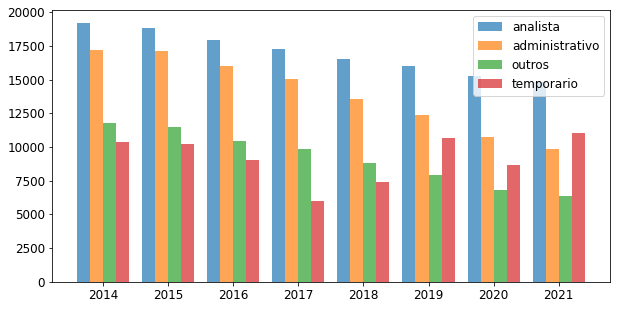

In [38]:
pl.figure(figsize=(10,5))
xu.multiple_bars_plot(servidor_counts_df.loc[2014:], alpha=0.7)
pl.legend(fontsize=12)
pl.tick_params(labelsize=12)
pl.show()

### Evolução temporal das localidades

<AxesSubplot:>

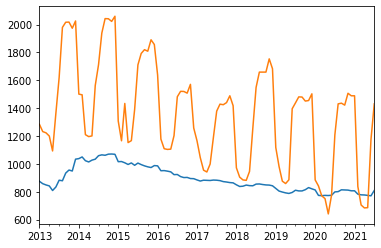

In [66]:
df.loc[df['uf'].isnull(), 'data'].value_counts().sort_index().plot()
servidor_counts_by_date(df, 'uf', amz_legal).plot()
pl.show()

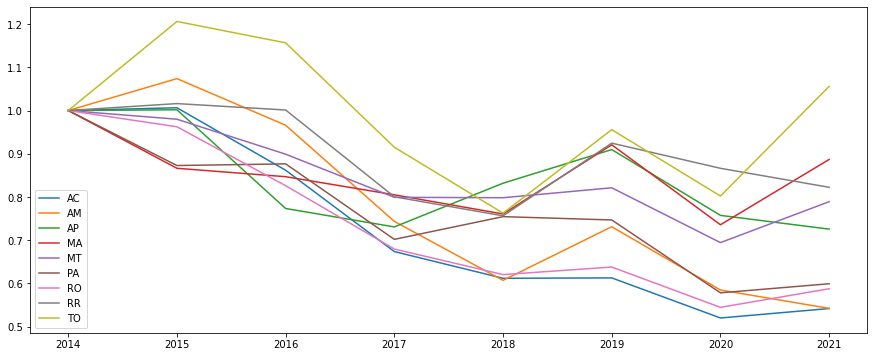

In [71]:
pl.figure(figsize=(15,6))
for uf in amz_legal:
    y = servidor_counts_by_date(df, 'uf', uf, time_col='ano_prodes').loc[2014:] 
    (y / y.iloc[0]).plot(label=uf)
pl.legend()
pl.show()    

## Evolução geral do número de servidores

In [6]:
n_servidores_ano_prodes = df['ano_prodes'].value_counts(sort=False).loc[2014:] / 12

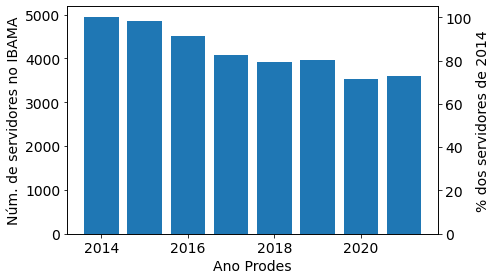

In [7]:
fig, ax1 = pl.subplots(figsize=(7,4))

# add second axis with different units, update it whenever ax1 changes
ax2 = ax1.twinx()

x = n_servidores_ano_prodes

def convert_ax2(ax1):
    y1, y2 = ax1.get_ylim()
    ax2.set_ylim(y1/max(x) * 100, y2/max(x) * 100)
    ax2.figure.canvas.draw()    

ax1.callbacks.connect("ylim_changed", convert_ax2)   

ax1.bar(x.index, x)

ax1.set_xlabel('Ano Prodes', fontsize=14)
ax1.set_ylabel('Núm. de servidores no IBAMA', fontsize=14)
ax2.set_ylabel('% dos servidores de 2014', fontsize=14)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
pl.tight_layout()
pl.show()

## Tipos de cargos

In [16]:
df['desc_cargo'].value_counts(normalize=True)

ANALISTA AMBIENTAL                         0.341223
TECNICO ADMINISTRATIVO                     0.280209
Inválido                                   0.192071
TECNICO AMBIENTAL                          0.068813
Sem informação                             0.066331
ANALISTA ADMINISTRATIVO                    0.043202
AUXILIAR ADMINISTRATIVO                    0.006151
PROCURADOR FEDERAL                         0.000448
ADMINISTRADOR                              0.000272
AGENTE ADMINISTRATIVO                      0.000244
AAD-AUX DE RECURSOS MATERIAIS              0.000239
ASG - AJUDANTE GERAL                       0.000239
FISCAL DE CADASTRO E TRIBUTACAO RURAL      0.000139
DEC JUD - ANALISTA AMBIENTAL               0.000121
TEC COMUNICACAO SOCIAL                     0.000074
CONTADOR                                   0.000053
ENGENHEIRO FLORESTAL                       0.000046
ANALISTA-A                                 0.000026
ANALISTA DE INFRA-ESTRUTURA                0.000023
ANALISTA EM 

### Cargos sem informação

In [44]:
sem_cargo = df.loc[df['desc_cargo'].isin(['Inválido'])]
sem_cargo['situacao_vinculo'].value_counts()

CONTRATO TEMPORARIO     75548
EXERC DESCENT CARREI     6208
EXERCICIO PROVISORIO      380
EXERC. 7  ART93 8112      369
CEDIDO/REQUISITADO        105
ESTAGIARIO SIGEPE          91
EXERC.‚7Ì ART93 8112        7
EXERC.§7º ART93 8112        3
Name: situacao_vinculo, dtype: int64

In [43]:
sem_cargo = df.loc[df['desc_cargo'].isin(['Sem informação'])]
sem_cargo['situacao_vinculo'].value_counts()

ATIVO PERMANENTE        21954
EXERC DESCENT CARREI     3047
NOMEADO CARGO COMIS.     2087
CEDIDO/REQUISITADO       1270
REQ.DE OUTROS ORGAOS      138
REQ. MILITAR F. ARM        35
APOSENTADO                 25
ESTAGIARIO SIGEPE           5
EXERC.‚7Ì ART93 8112        2
ATIVO EM OUTRO ORGAO        1
Name: situacao_vinculo, dtype: int64

In [32]:
# 
sem_cargo['regime_juridico'].value_counts()

CONTRATO TEMPORARIO                  75548
REGIME JURIDICO UNICO                35377
CONSOLIDACAO DAS LEIS DO TRABALHO      254
ESTAGIO                                 96
Name: regime_juridico, dtype: int64

In [35]:
xd.print_array_series(xd.check_guarda_compartilhada(df, 'situacao_vinculo', 'regime_juridico', drop_unique=False))

APOSENTADO: REGIME JURIDICO UNICO
ATIVO EM OUTRO ORGAO: CONSOLIDACAO DAS LEIS DO TRABALHO / REGIME JURIDICO UNICO
ATIVO PERMANENTE: REGIME JURIDICO UNICO
CEDIDO/REQUISITADO: REGIME JURIDICO UNICO / CONSOLIDACAO DAS LEIS DO TRABALHO
CELETISTA/EMPREGADO: CONSOLIDACAO DAS LEIS DO TRABALHO
CLT ANS -DEC 6657/08: CONSOLIDACAO DAS LEIS DO TRABALHO
CONTRATO TEMPORARIO: CONTRATO TEMPORARIO
ESTAGIARIO SIGEPE: ESTAGIO
EXERC DESCENT CARREI: REGIME JURIDICO UNICO
EXERC. 7  ART93 8112: REGIME JURIDICO UNICO / CONSOLIDACAO DAS LEIS DO TRABALHO
EXERC.§7º ART93 8112: REGIME JURIDICO UNICO
EXERC.‚7Ì ART93 8112: CONSOLIDACAO DAS LEIS DO TRABALHO / REGIME JURIDICO UNICO
EXERCICIO PROVISORIO: REGIME JURIDICO UNICO
NOMEADO CARGO COMIS.: REGIME JURIDICO UNICO
REQ. MILITAR F. ARM: REGIME JURIDICO UNICO
REQ.DE OUTROS ORGAOS: REGIME JURIDICO UNICO


In [28]:
xu.mapUnique(sem_cargo)


data: 103 unique values.
(sample) 2013-03-01T00:00:00.000000000,  2015-03-01T00:00:00.000000000,  2015-06-01T00:00:00.000000000,  2015-09-01T00:00:00.000000000,  2015-10-01T00:00:00.000000000,  2015-11-01T00:00:00.000000000,  2015-12-01T00:00:00.000000000,  2016-06-01T00:00:00.000000000,  2016-09-01T00:00:00.000000000,  2016-10-01T00:00:00.000000000,  2016-11-01T00:00:00.000000000,  2017-07-01T00:00:00.000000000,  2017-11-01T00:00:00.000000000,  2018-05-01T00:00:00.000000000,  2018-08-01T00:00:00.000000000,  2018-09-01T00:00:00.000000000,  2019-06-01T00:00:00.000000000,  2019-09-01T00:00:00.000000000,  2020-06-01T00:00:00.000000000,  2020-09-01T00:00:00.000000000

id_servidor: 8140 unique values.
(sample) 566345,  607175,  2201059,  3203450,  3600838,  4311183,  4314835,  4314894,  6007722,  7013736,  7311787,  9009292,  9317649,  9416817,  72415918,  74527537,  76314459,  76926212,  77805688,  110918542

desc_cargo: 2 unique values.
Inválido,  Sem informação

sigla_funcao: 5 unique v

In [15]:
df['situacao_vinculo'].value_counts(normalize=True)

ATIVO PERMANENTE        0.789326
CONTRATO TEMPORARIO     0.175437
EXERC DESCENT CARREI    0.021492
NOMEADO CARGO COMIS.    0.004846
CEDIDO/REQUISITADO      0.003193
APOSENTADO              0.002608
EXERCICIO PROVISORIO    0.000882
EXERC. 7  ART93 8112    0.000857
ATIVO EM OUTRO ORGAO    0.000673
REQ.DE OUTROS ORGAOS    0.000320
ESTAGIARIO SIGEPE       0.000223
REQ. MILITAR F. ARM     0.000081
CELETISTA/EMPREGADO     0.000026
EXERC.‚7Ì ART93 8112    0.000021
CLT ANS -DEC 6657/08    0.000007
EXERC.§7º ART93 8112    0.000007
Name: situacao_vinculo, dtype: float64

## Evolução no número de servidores do IBAMA

**Quem são os duplicados?**

* Um dos cargos é sempre "Sem informação" ou "Inválido", o outro é ANALISTA, PROCURADOR ou TECNICO ADMINISTRATIVO.
* Uma função é comissionada, a outra é inexistente.
* Uma atividade é "Sem informação", a outra é de chefe (e.g. Superintendente, Chefe, Coordenador).

**Conclusão:** São pessoas com funções comissionadas e pessoas em exercício descentralizado da carreira.

Entre os duplicados, eliminar:
* Aquele com sigla_funcao = -1
* Aquele com situacao_vinculo = 'ATIVO PERMANENTE' ao invés de 'EXERC DESCENT CARREI' ou 'EXERCICIO PROVISORIO'

In [278]:
# Selecionando dados duplicados:
sel = df.loc[df.duplicated(subset=['data', 'id_servidor'], keep=False)]

In [274]:
# Colunas que se alteram frequentemente entre servidores duplicados:
diff_cols = ['desc_cargo', 'sigla_funcao', 'atividade', 'situacao_vinculo']

In [275]:
# Verificando a quantidade de duplicatas com variação na coluna selecionada:
sel.groupby(['data', 'id_servidor'])['desc_cargo'].nunique().value_counts()

Series([], Name: desc_cargo, dtype: int64)

In [158]:
# Servidores com duplicatas:
cases = sel[['data', 'id_servidor']].drop_duplicates().sample(1000)

In [261]:
# Mostra dados que variam para um servidor com duplicatas:
i = 5
servidor = sel.loc[(sel[['data', 'id_servidor']] == cases.iloc[i]).all(axis=1)]
servidor.transpose().loc[(servidor != servidor.iloc[0]).any()]

,51547,51548
desc_cargo,Sem informação,PROCURADOR FEDERAL
sigla_funcao,DAS,-1
nivel_funcao,1012,-1
atividade,CHEFE DE DIVISAO,Sem informação
cod_uorg_exercicio,40106000000619,40701000000619
uorg_exercicio,CONJUR DO MAPA/DFA/MG,DIVISAO JURIDICA - SC
situacao_vinculo,EXERC DESCENT CARREI,ATIVO PERMANENTE


## Investigação da sazonalidade

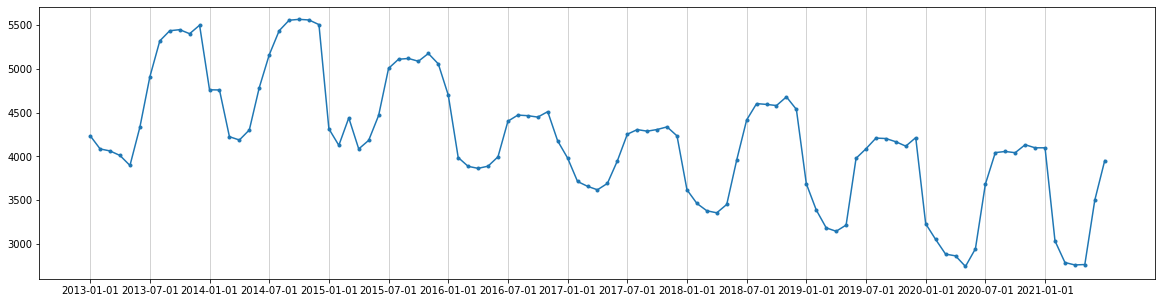

In [5]:
pl.figure(figsize=(20,5))
pl.plot(df.drop_duplicates(subset=['id_servidor', 'data']).value_counts('data').sort_index(), marker='.')
ticks_labels = (pd.date_range('2012-12-31', '2020-12-31', freq='M') + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
ticks_pos = list(range(len(ticks_labels)))
pl.xticks(ticks_pos[::6], labels=ticks_labels[::6])
pl.grid(axis='x', color='lightgray', linewidth=1)
pl.show()

In [6]:
# Identificação dos servidores extras do segundo semestre:
id_low  = df.loc[df['data'] == '2013-05-01']
id_high = df.loc[df['data'] == '2013-09-01']
inbound  = set(id_high['id_servidor']) - set(id_low['id_servidor'])
outbound = set(id_low['id_servidor'])  - set(id_high['id_servidor'])

### A variação vêm de contratos temporários

In [40]:
# Existe uma correspondência biunívoca para CONTRATOS TEMPORÁRIOS:
print(df.loc[df['regime_juridico'] == 'CONTRATO TEMPORARIO', 'situacao_vinculo'].unique())
print(df.loc[df['situacao_vinculo'] == 'CONTRATO TEMPORARIO', 'regime_juridico'].unique())

['CONTRATO TEMPORARIO']
['CONTRATO TEMPORARIO']


In [7]:
extras = id_high.loc[id_high['id_servidor'].isin(inbound)]
extras['situacao_vinculo'].value_counts()

CONTRATO TEMPORARIO     1370
ATIVO PERMANENTE         234
APOSENTADO                15
ATIVO EM OUTRO ORGAO       2
EXERC DESCENT CARREI       1
CEDIDO/REQUISITADO         1
Name: situacao_vinculo, dtype: int64

In [8]:
id_low['situacao_vinculo'].value_counts()

ATIVO PERMANENTE        4042
EXERC DESCENT CARREI     104
CONTRATO TEMPORARIO       37
ATIVO EM OUTRO ORGAO      24
CEDIDO/REQUISITADO        20
NOMEADO CARGO COMIS.      16
EXERCICIO PROVISORIO       4
EXCEDENTE A LOTACAO        1
CELETISTA/EMPREGADO        1
REQ.DE OUTROS ORGAOS       1
Name: situacao_vinculo, dtype: int64

In [9]:
id_high['situacao_vinculo'].value_counts()

ATIVO PERMANENTE        4207
CONTRATO TEMPORARIO     1405
EXERC DESCENT CARREI     101
CEDIDO/REQUISITADO        20
ATIVO EM OUTRO ORGAO      17
APOSENTADO                16
NOMEADO CARGO COMIS.      14
EXERCICIO PROVISORIO       2
CELETISTA/EMPREGADO        1
REQ.DE OUTROS ORGAOS       1
Name: situacao_vinculo, dtype: int64

### Para quê os contratos temporários?

In [10]:
extras['uorg_exercicio'].value_counts().head(20)

PREVFOGO-BRIG. MUNIC. PORTO VELHO/RO        61
PREVFOGO-BRIG.MUNIC. BRASÍLIA/DF            45
PREVFOGO-BRIG.MUNIC. FORM.DO ARAGUAIA/TO    30
PREVFOGO-BRIG.MUNIC.AMARANTE MARANH/MA      30
PREVFOGO-BRIGADA MUN.SAO JOAO MISSOES/MG    30
PREVFOGO-BRIG.MUNICIPAL CORUMBÁ/MS          30
PREVFOGO-BRIG.MUNIC. SAO FELIX XINGU/PA     29
PREVFOGO-BRIG.MUNICIPAL COTRIGUACU/MT       29
PREVFOGO-BRIG.MUNICIPAL BARREIRAS/BA        29
PREVFOGO-BRIG. MUNICIPAL PIUM/TO            29
PREVFOGO-BRIG.MUNIC. MACHADINHO OESTE/RO    29
prevfogo-brigada mun. canto do buritis      29
PREVFOGO-BRIG.MUNIC. NOVO PROGRESSO/PA      29
PREVFOGO-BRIG.MUNIC.PARANATINGA/MT          29
PREVFOGO-BRIG.MUNICIPAL GRAJAÚ/MA           29
PREVFOGO-BRIGADA MUN. CAVALCANTE/GO         29
PREVFOGO-BRIG.MUNICIPAL ITAITUBA/PA         29
PREVFOGO-BRIG.MUNIC.SERRA NOVA DOURADA      29
PREVFOGO-BRIG. MUNIC. ITUPIRANGA/PA         29
PREVFOGO-BRIG.MUNICIPAL EM ITAETE/BA        28
Name: uorg_exercicio, dtype: int64

In [11]:
extras['desc_cargo'].value_counts()

Inválido                       1370
TECNICO ADMINISTRATIVO          229
ANALISTA AMBIENTAL                9
ANALISTA ADMINISTRATIVO           4
ADMINISTRADOR                     3
Sem informação                    2
TEC COMUNICACAO SOCIAL            1
ANALISTA DE INFRA-ESTRUTURA       1
AGENTE ADMINISTRATIVO             1
MEDICO VETERINARIO                1
CONTADOR                          1
ENGENHEIRO FLORESTAL              1
Name: desc_cargo, dtype: int64

In [12]:
extras['atividade'].value_counts()

Sem informação         1621
CHEFE DE UNIDADE II       1
COORDENADOR               1
Name: atividade, dtype: int64

In [13]:
extras['org_lotacao'].value_counts()

Instituto Brasileiro do Meio Ambiente e Recur    1618
Instituto Chico Mendes de Conservação da Biod       3
Ministério do Planejamento, Desenvolvimento e       2
Name: org_lotacao, dtype: int64

In [14]:
extras.sample(5).transpose()

,38952,42778,37892,42056,41674
data,2013-09-01,2013-09-01,2013-09-01,2013-09-01,2013-09-01
id_servidor,8607008,7509496,6401586,4403115,9009637
desc_cargo,Inválido,TECNICO ADMINISTRATIVO,Inválido,Inválido,Inválido
sigla_funcao,-1,-1,-1,-1,-1
nivel_funcao,-1,-1,-1,-1,-1
atividade,Sem informação,Sem informação,Sem informação,Sem informação,Sem informação
cod_uorg_lotacao,-3,40701000000031,-3,-3,-3
uorg_lotacao,Inválido,COORD. LICITAÇÕES CONTRATOS E MATERIAIS,Inválido,Inválido,Inválido
cod_org_lotacao,40701,40701,40701,40701,40701
org_lotacao,Instituto Brasileiro do Meio Ambiente e Recur,Instituto Brasileiro do Meio Ambiente e Recur,Instituto Brasileiro do Meio Ambiente e Recur,Instituto Brasileiro do Meio Ambiente e Recur,Instituto Brasileiro do Meio Ambiente e Recur


# Lixo

In [59]:
def sort_names(name_list):
    
    # Sort por tamanho do nome (maiores no final):
    lengths = [len(s) for s in name_list]
    order   = np.argsort(lengths)
    ordered = np.array(name_list)[order]
    
    return ordered

#### Old features e alvo para modelo de número médio de servidores

In [ ]:
y_series = (df.groupby('uf')['ano_prodes'].value_counts() / 12).sort_index()
y_series.name = 'n_medio_anterior'
y_series = y_series.shift().reset_index()
y_series.loc[~xu.same_as_previous_entry(y_series[['uf']]), 'n_medio_anterior'] = np.NaN

In [305]:
monthly_data = df.groupby(['uf', 'ano_prodes'])['data'].value_counts().sort_index(ascending=False)
monthly_data.name = 'n_mes'
monthly_data = monthly_data.reset_index()
monthly_data['mes'] = monthly_data['data'].dt.month
monthly_data = monthly_data.loc[monthly_data['ano_prodes'] > 2013]
monthly_data = monthly_data.pivot(index=['uf', 'ano_prodes'], columns='mes', values='n_mes')
monthly_data = monthly_data.sort_index(ascending=False)

In [312]:
# Cria base com # de servidores em dezembro do ano prodes anterior:
pep_dez = ativos_pep_ibama.loc[(ativos_pep_ibama['Mês'] == 12) & (ativos_pep_ibama['ano_prodes'] > 2012)].groupby(['UF Servidores', 'ano_prodes'])['Servidores'].sum().sort_index()
pep_dez.name = 'n_dez_anterior'
pep_dez = pep_dez.shift().reset_index()
pep_dez.loc[~xu.same_as_previous_entry(pep_dez[['UF Servidores']]), 'n_dez_anterior'] = np.NaN

In [323]:
Xy_df = monthly_data.join(pep_dez.set_index(['UF Servidores', 'ano_prodes']), on=['uf', 'ano_prodes']).join(y_series.set_index(['uf', 'ano_prodes']), on=['uf', 'ano_prodes'])
Xy_df = Xy_df.loc[Xy_df.index.get_level_values('ano_prodes') > 2014].head(20)